<a href="https://colab.research.google.com/github/codyub/ESAA/blob/main/%ED%95%B8%EC%A6%88%EC%98%A8_4%EC%9E%A5_%EB%AA%A8%EB%8D%B8_%ED%9B%88%EB%A0%A8_p_157_202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04 모델 훈련

# 선형 회귀를  훈련 시키는 방법
> 1) 직접 계산할 수 있는 공식을 사용해 훈련 세트에 가장 잘 맞는 모델 파라미터(즉, 훈련 세트에 대해 비용 함수를 최소화 하는 모델 파라미터)를 해석적으로 구함

> 2) 경사 하강법(반복적인 최적화 방식을 사용해 모델 파라미터를 바꾸며 비용 함수를 훈련 세트에 대해 최소화 시킴, 배치 경사 하강법, 미니배치 경사 하강법, 확률적 경사 하강법) 사용

# 다항 회귀
- 비선형 데이터셋에 훈련 가능
- 파라미터가 많다 --> 훈련 데이터에 과대적합되기 쉽습니다.
- 학습 곡선을 사용해 모델이 과대적합 되는지 감지

# 로지스틱 회귀, 소프트맥스 회귀


# 4.1 선형 회귀
- 일반적으로 선형 모델은 입력 특성의 가중치 합과 편향(절편)이라는 상수를 더해 예측을 만든다. 이를 벡터 형태로 쓸 수 있다. 이것이 선형 회귀.

-훈련시킨다: 모델이 훈련 세트에 가장 잘 맞도록 모델 파라미터를 설정하는 것. 모델이 훈련 데이터에 얼마나 잘 들어맞는지 측정해야 한다. 가장 널리 사용되는 성능 측정 지표는 RMSE(평균제곱근오차).

# 4.1.1 정규방정식
- 비용함수를 최소화하는 theta 값을 찾기 위한 해석적인 방법 = 정규 방정식


# 정규 방정식 테스트

1) 무작위 데이터셋 생성

In [1]:
import numpy as np

X=2*np.random.rand(100, 1)
y=4+3*X+np.random.randn(100, 1)

2) 정규 방정식을 이용한 계산

In [2]:
X_b=np.c_[np.ones((100,1)), X] #모든 샘플에 x0=1 추가
theta_best=np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [3]:
theta_best

array([[4.14539169],
       [2.96570672]])

- theta0=4, theta1=3을 기대했지만, 잡음때문에 원래 함수의 파라미터를 정확하게 재현하지 못했다.
- theta를 사용해 예측해보자

In [4]:
X_new=np.array([[0], [2]])
X_new_b=np.c_[np.ones((2,1)), X_new] #모든 샘플에 x0=1 추가
y_predict=X_new_b.dot(theta_best)
y_predict     

array([[ 4.14539169],
       [10.07680513]])

- 모델 예측을 그래프에 나타내기

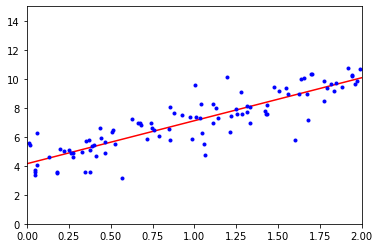

In [5]:
import matplotlib.pyplot as plt

plt.plot(X_new, y_predict, 'r-')
plt.plot(X, y, 'b.')
plt.axis([0,2,0,15])
plt.show()

# 사이킷런에서 선형 회귀 수행하기

In [6]:
from sklearn.linear_model import LinearRegression
lin_reg=LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.14539169]), array([[2.96570672]]))

In [7]:
lin_reg.predict(X_new)

array([[ 4.14539169],
       [10.07680513]])

- LinearRegression 클래스는 scipy.linalg.lstsq() 함수를 기반으로 한다.

# scipy.linalg.lstsq() 직접 호출하기

In [8]:
theta_best_svd, residuals, rank, s =np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[4.14539169],
       [2.96570672]])

# 유사역행렬 구하기: np.linalg.pinv()

In [9]:
np.linalg.pinv(X_b).dot(y)

array([[4.14539169],
       [2.96570672]])

- 유사역행렬 자체는 특잇값 분해(SVD)라고 부르는 표준 행렬 분해 기법을 사용해 계산 
- 정규방정식보다 훨씬 효율적이고, 극단적인 경우도 처리할 수 있으며, 유사역행렬은 역행렬과 달리 항상 구할 수 있다.

# 4.1.2 계산 복잡도
- 정규방정식은 (n+1)(n+1)크기가 되는 Xt*X의 역행렬을 계산 
- 역행렬을 계산하는 계산 복잡도는 특성 수가 두 배로 늘어나면 계산 시간이 대략 2^2.4=5.3에서 2^3=8배 증가한다. = (O(n^2.4)) 에서 O(n^3))
- 사이킷런의 LinearRegression 클래스가 사용하는 SVD 방법은 약 O(n^2). 또한 학습된 선형 회귀 모델은 예측이 매우 빠르다.
- 예측 계산 복잡도는 샘플 수와 특성 수에 선형적 = 예측 하려는 샘플이 두 배로 늘어나면 걸리는 시간도 거의 두 배 증가


# 4.2 경사하강법(GD)
- 특성이 매우 많고 훈련 샘플이 너무 많아 메모리에 모두 담을 수 없을 때 적합한 방법
- 비용함수를 최소화 하기 위해 반복해서 파라미터를 조정
- 파라미터 벡터 세타에 대해 비용 함수의 현재 그래디언트를 계산해 그래디언트가 감소하는 방향으로 진행 --> 0이 되면 최솟값에 도달
- 경사 하강법에서 중요한 파라미터는 스텝의 크기로, 학습률 파라미터로 결정
- 너무 작으면 알고리즘이 수렴하기 위해 반복을 많이 진행해야 하므로 시간 증가, 너무 크면 골짜기를 가로질러 반대편으로 건너뛰게 되어 전보다 높은 곳으로 갈 가능성
- 다양한 지형이 있으면 최솟값으로 수렴하기가 어려움: 전역 최솟값이 아닌 지역 최솟값에 수렴하거나, 평탄한 지역을 지나지 못하고 일찍 멈추는 문제. 
- 하지만 선형 회귀를 위한 MSE 비용 함수는 볼록 함수 = 지역 최솟값이 없고, 하나의 전역 최솟값만 있음, 연속된 함수이고 기울기가 갑자기 변하지 않음
-  비용 함수는 특성들의 스케일이 매우 다르면 그릇 모양이 아닌, 길쭉한 모양일 수 있음
- 결국 최솟값에 도달하긴 하지만 시간이 오래 걸릴 것. -> 경사 하강법 사용 시 모든 특성이 같은 스케일을 갖도록 StandardScaler 등 이용


# 4.2.1 배치 경사 하강법
- 경사 하강법을 구현하려면 각 모델 파라미터 thetaj에 대해 비용 함수의 그래디언트를 계산해야 함. --> thetaj가 조금 변경될 때 비용 함수가 얼마나 바뀌는지 계산해야 한다. = 편도함수.
- 이 공식은 매 경사 하강법 스텝에서 전체 훈련 세트 X에 대해 계산 = 이 알고리즘을 배치 경사 하강법이라고 함 --> 큰 훈련 세트에서 느림, but 특성 수에 민감하지 않다.



# 알고리즘을 구현

In [10]:
eta=0.1 #학습률
n_iterations=100
m=100

theta=np.random.randn(2,1) #무작위 초기화

for iteration in range(n_iterations):
  gradients=2/m * X_b.T.dot(X_b.dot(theta)-y)
  theta=theta-eta*gradients

In [11]:
theta

array([[4.09628113],
       [3.00786785]])

# 세 가지 학습률을 사용한 경사 하강법의 스텝 처음 10개
- 점선은 시작점
- 학습률: 너무 낮으면 시간이 오래 걸림
- 너무 높으면 알고리즘이 이리저리 널뛰면서 발산 
- 적절한 학습률을 찾으려면 반복 횟수를 제한한 그리드 탐색을 사용: 반복 횟수는 일단 크게 지정하고, 그래디언트 벡터가 아주 작아지면 경사 하강법이 거의 최솟값에 도달한 것으로 보고 중지.

# 4.2.2 확률적 경사 하강법
- 배치 하강법은 매 스텝에서 전체 훈련 세트를 사용해 그레디언트를 계산함 --> 훈련 세트가 커지면 느려질 것 
- 확률적 경사 하강법은 매 스텝에서 한 개의 샘플을 무작위로 선택해 그 하나의 샘플에 대한 그래디언트를 계산. 훨씬 빠르고 매우 큰 훈련 세트도 훈련시킬 수 있음
- 그러나 확률적이기 때문에 배치 경사 하강법보다 불안정 --> 요동치며 수렴. 
- 알고리즘이 멈출 때 좋은 파라미터가 구해지긴 하지만 최적치는 아닐 것. 비용 함수가 불규칙하면 좋음.
- 무작위성은 지역 최솟값에서는 탈출시켜주지만 전역 최솟값에는 다다르지 못하게 할 수도 있음 --> 학습률을 점진적으로 감소시키면 해결 가능(시작할 때는 크게 하고 점차 작게 줄여서 알고리즘이 전역 최솟값에 도달하게 함). 
- 매 반복에서 학습률을 결정하는 함수: 학습 스케줄

# 학습 스케쥴을 사용한 확률적 경사 하강법의 구현

In [12]:
n_epochs=50
t0, t1=5, 50 #학습 스케줄 하이퍼 파라미터

def learning_schedule(t):
  return t0/(t+t1)

theta = np.random.randn(2,1) #무작위 초기화

for epoch in range(n_epochs):
  for i in range(m):
    random_index=np.random.randint(m)
    xi=X_b[random_index:random_index+1]
    yi=y[random_index:random_index+1]
    gradients=2*xi.T.dot(xi.dot(theta)-yi)
    eta=learning_schedule(epoch*m+i)
    theta=theta-eta*gradients

- 일반적으로 한 반복에서 m번 되풀이, 이 각 반복을 에포크라고 함
- 배치 경사 하강법이 전체 훈련 세트에 대해 1000번 반복하는 동안 이 코드는 50번만 반복하고도 매우 좋은 값에 도달

In [13]:
theta

array([[4.19106641],
       [2.99333006]])

- 샘플을 무작위로 선택하므로 어떤 샘플은 여러 번 선택될 수도 있고 어떤 샘플은 선택되지 못할 수도 있다. 알고리즘이 모든 샘플을 사용하게 하려면 훈련 세트를 섞은 후 차례대로 하나씩 선택한 후 다음 에포크에서 다시 섞는 방법을 사용할 수 있다. 조금 더 시간이 걸림.
- 사이킷런에서 SGD 방식으로 선형 회귀를 사용하려면 기본값으로 제곱 오차 비용 함수를 최적화하는 SGDRegressor 클래스를 사용함

# 사이킷런에서 SGD 방식으로 선형 회귀
- 규제 X, 최대 1000번 에포크 동안 실행, 또는 한 에포크에서 0.001보다 적게 손실이 줄어들때까지 실행

In [14]:
from sklearn.linear_model import SGDRegressor
sgd_reg=SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1)
sgd_reg.fit(X, y.ravel())

SGDRegressor(eta0=0.1, penalty=None)

In [15]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.09527388]), array([2.91936719]))

- 정규 방정식과 비슷한 값 얻음

# 4.2.3 미니배치 경사 하강법
- 각 스텝에서 전체 훈련 세트나 하나의 샘플을 기반으로 그레디언트를 계산하는 것이 아니라, 미니배치라 부르는 임의의 작은 샘플 세트에 대해 그레이디언트를 계산
- 행렬 연산에 최적화된 하드웨어, 특히 GPU를 얻는 성능 향상
- 미니 배치를 어느정도 크게 하면 알고리즘은 파라미터 공간에서 SGD보다 덜 불규칙하게 움직임
- SGD보다 최솟값에 더 가까이 도달하게 될 것, 하지만, 지역 최솟값에서는 더 빠져나오기 어려울 수도 있음
- 알고리즘을 비교한 것은 176p
- 서로 다른 알고리즘들은 훈련 결과에 거의 차이가 없고, 매우 비슷한 모델을 만들고 정확히 같은 방식으로 예측

# 4.3 다항회귀
- 가지고 있는 데이터가 복잡한 형태일때
- 특성이 여러개일 때 특성 사이의 관계를 찾을 수 있음: 주어진 차수까지 특성 간의 모든 교차항을 추가하기 때문

# 예시: 2차 방정식 형태의 데이터
- 잡음이 포함된 비선형 데이터셋

In [16]:
m=100
X=6*np.random.rand(m, 1)-3
y=0.5*X**2+X+2+np.random.randn(m,1)

# PolynomialFeatures
- 훈련 데이터를 변환: 훈련 세트에 있는 각 특성을 제곱해 새로운 특성으로 추가

In [17]:
from sklearn.preprocessing import PolynomialFeatures

poly_features=PolynomialFeatures(degree=2, include_bias=False)
X_poly=poly_features.fit_transform(X)
X[0]

array([0.12693123])

- X_poly는 이제 원래 특성 X와 이 특성의 제곱을 포함

In [18]:
X_poly[0]

array([0.12693123, 0.01611154])

# 확장된 훈련 데이터에 linear regression 적용

In [19]:
lin_reg=LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_     

(array([2.16086647]), array([[1.05088415, 0.47279284]]))

- 원래 함수: y=0.5x1^2+1.0x1+2+가우시안 잡음
--> 큰 차이 없음

# 4.4 학습 곡선
- 고차 다항 회귀를 적용하면 보통의 선형 회귀에서보다 더 훈련 데이터에 잘 맞추려 함
- 어떻게 모델이 데이터에 과대적합 또는 과소적합되었는지 알 수 있는가? 
- 훈련 데이터에서 성능이 좋지만 교차 검증 점수가 나쁘면 모델이 과대적합 된 것, 둘 다 좋지 않으면 과소적합
- 학습 곡선: 훈련 세트와 검증 세트의 모델 성능을 훈련 세트 크기의 함수로 나타냄. 훈련 세트에서 크기가 다른 서브 세트를 만들어 모델을 여러번 훈련 시켜 만듦.

# 학습 곡선 그리기

In [20]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
  X_train, X_val, y_train, y_val=train_test_split(X, y, test_size=0.2)
  train_errors, val_errors=[], []
  for m in range(1, len(X_train)):
    model.fit(X_train[:m], y_train[:m])
    y_train_predict=model.predict(X_train[:m])
    y_val_predict=model.predict(X_val)
    train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))
  plt.plot(np.sqrt(train_errors), 'r-+', linewidth=2, label='훈련 세트')
  plt.plot(np.sqrt(val_errors), 'b-', linewidth=3, label='검증 세트')
    

#단순 선형 회귀 모델의 학습 곡선

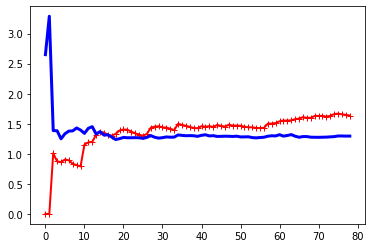

In [21]:
lin_reg=LinearRegression()
plot_learning_curves(lin_reg, X, y)

- 그래프가 0에서 시작하므로, 훈련 세트에 하나 혹은 두 개의 샘플이 있을 때는 모델이 완벽하게 작동
- 훈련 세트에 샘플이 추가됨에 따라 잡음도 있고, 비선형이기 때문에 모델이 훈련 데이터를 완벽히 학습하는 것은 불가능
- 그래서 곡선이 어느 정도 평편해질 때까지 오차가 계속 상승
- 이 위치에서는 훈련 세트에 샘플이 추가 되어도 평균 오차가 크게 나아지거나 나빠지지 않음


# 검증 데이터에 대한 모델의 성능
- 모델이 적은 수의 훈련 샘플로 훈련될 때는 제대로 일반화 될 수 없어, 검증 오차가 초기에 매우 큼
- 모델에 훈련 샘플이 추가됨에 따라 학습이 되고 검증 오차가 천천히 감소
- 선형 회귀의 직선은 데이터를 잘 모델링 할 수 없으므로 오차의 감소가 완만해져 훈련 세트의 그래프와 가까워짐
- 모델이 훈련 데이터에서 과소적합 되어 있다면 훈련 샘플을 더 추가해도 효과가 없다. 더 복잡한 모델을 사용하거나 더 나은 특성을 선택해야 한다. 

# 10차 다항 회귀 모델의 학습 곡선

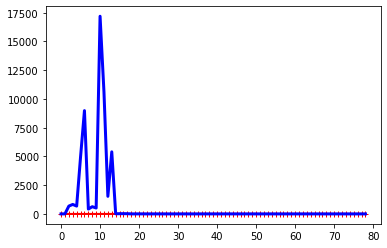

In [22]:
from sklearn.pipeline import Pipeline

polynomial_regression=Pipeline([('poly_features', PolynomialFeatures(degree=10, include_bias=False)), ('lin_reg', LinearRegression())])
plot_learning_curves(polynomial_regression, X, y)

- 훈련 데이터의 오차가 선형 회귀보다 매우 낮음
- 두 곡선 사이에 공간이 있음 = 훈련 데이터에서의 모델 성능이 검증 데이터에서보다 낫다 = 과대적합 모델의 특징 -> 더 큰 훈련 세트를 사용하면 두 곡선이 점점 가까워짐
- 과대적합 모델 개선 방법 중 하나: 검증 오차가 훈련 오차에 근접할 때까지 더 많은 훈련 데이터를 추가

# 4.5 규제가 있는 선형 모델


- 과대적합을 감소시키는 방법: 모델을 규제하는 것 = 모델을 제한함
- 자유도를 줄이면 데이터에 과대적합 되기 더 어려워짐, 다항회귀 모델의 규제는 다항식의 차수를 감소시키는 것
- 선형 회귀 모델에서는 모델의 가중치를 제한함으로써 규제를 가함

# 4.5.1 릿지 회귀
- 규제항 : alpha * sum theta^2
- alpha: 모델을 얼마나 많이 규제할지 조절, 0이면 릿지 회귀는 선형 회귀, 너무 크면 모든 가중치가 거의 0에 가까워져 결국 데이터 평균을 지나는 수평선(모델의 분산을 줄이고 편향이 커짐)
- 규제항은 훈련하는 동안에만 비용 함수에 추가
- 모델 훈련이 끝나면 모델 성능을 규제가 없는 성능 지표로 평가
- 입력 특성의 스케일에 민감해 수행 전 데이터의 스케일을 맞추는 것이 중요

# 정규방정식을 사용한 릿지 회귀

In [23]:
from sklearn.linear_model import Ridge
ridge_reg=Ridge(alpha=1, solver='cholesky')
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[5.04941028]])

# 확률적 경사하강법을 사용한 릿지 회귀 : L2 = 릿지

In [24]:
sgd_reg=SGDRegressor(penalty='l2')
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([5.03063525])

# 4.5.2 라쏘 회귀
- 규제항 : alpha * sum |theta|
- 덜 중요한 특성의 가중치를 제거하려고 하는 경향 = 자동으로 특성을 선택하고 희소 모델을 만든다. 
- 비용함수가 theta = 0에서 미분 불가능 --> 서브 그레이디언트 벡터를 사용하면 경사 하강법을 적용하는 데 문제X

* 라쏘와 차이점 *
- 파라미터가 전역 최적점에 가까워질수록 그레이디언트가 작아짐 --> 경사 하강법이 느려지고 수렴에 도움(진동 없음)
- 알파를 증가시킬수록 최적의 파라미터가 원점에 더 가까워짐(완전히 0이 되지는 않음)



# 라쏘를 활용한 사이킷런 예제

In [25]:
from sklearn.linear_model import Lasso
lasso_reg=Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([5.00231301])

# SGDRegressor(penalty='l1')를 라쏘 대신 사용


In [26]:
sgd_reg=SGDRegressor(penalty='l1')
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([5.01859566])

# 4.5.3 엘라스틱넷

- 릿지와 라쏘 회귀의 절충
- 규제항: 릿지 회귀항과 회귀 규제항을 단순히 더함. 혼합 정도는 혼합비율 r을 사용해 조절
- r=1: 라쏘 회귀, r=0 릿지 회귀와 같아짐
- 일반적인 회귀에서는 릿지가 기본이 되지만, 특성이 몇 개뿐이면, 라쏘나 엘라스틱넷을 이용한다.
- 특성 수가 훈련 샘플 수보다 많거나 특성 몇 개가 강하게 연관되어 있으면 보통 라쏘가 문제를 일으키므로 라쏘보다는 엘라스틱넷을 선호함

# 엘라스틱넷을 이용한 예제

In [27]:
from sklearn.linear_model import ElasticNet
elastic_net=ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])
     

array([5.00216259])

# 4.5.4 조기 종료
- 반복적인 학습 알고리즘을 규제하는 방법 중 하나: 검증 에러가 최솟값에 도달하면 바로 훈련을 중지
- 에포크가 진행됨에 따라 알고리즘이 점차 학습되어 훈련 세트에 대한 예측 에러와 검증 세트에 대한 예측 에러가 줄어든다. -> 이후 다시 에러가 상승 : 모델이 훈련 데이터에 과대적합 되기 시작함
- 확률적 경사하강법이나 미니배치 경사하강법에서는 곡선이 별로 매끄럽지 않아, 최솟값에 도달했는지 확인하기 어려울 수도 있다. : 검증 에러가 일정 시간동안 최솟값보다 클 때 학습을 멈추고 검증 에러가 최소였을 때의 모델 파라미터로 되돌리는 것이 하나의 해결방법

# 조기 종료를 위한 기본적인 구현 코드

In [30]:
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler
X_train, X_val, y_train, y_val=train_test_split(X, y, test_size=0.2)

# 데이터 준비
poly_scaler = Pipeline([
    ("poly_features", PolynomialFeatures(degree=90, include_bias = False)),
    ("std_scaler", StandardScaler())
])
X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1, tol=None, warm_start=True,      # warm_start = True로 지정하면 fit() 메서드 호출될 때 처음부터 다시 시작하지 않고 이전 모델 파라미터에서 훈련 이어가  # tol 오류나 None으로 수정
                       penalty=None, learning_rate="constant", eta0=0.0005)
minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
  sgd_reg.fit(X_train_poly_scaled, y_train)   # 훈련을 이어서 진행합니다.
  y_val_predict = sgd_reg.predict(X_val_poly_scaled)
  val_error = mean_squared_error(y_val, y_val_predict)
  if val_error < minimum_val_error:
    minimum_val_error = val_error
    best_epoch = epoch
    best_model = clone(sgd_reg)

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

- warm_start=True면 fit()메서드가 호출될 때 처음부터 다시 시작하지 않고 이전 모델 파라미터에서 훈련을 이어간다.

# 4.6 로지스틱 회귀

# 4.6.1 확률 추정
- 로지스틱 회귀의 작동: 선형 회귀 모델과 같이 로지스틱 회귀는 입력 특성의 가중치 합을 계산하고 편향을 더함
- 대신 선형 회귀처럼 바로 결과를 출력하지 않고 결과값의 로지스틱을 출력한다. 
- 0과 1 사이의 값을 출력하는 S자 형태 시그모이드 함수.
- 로지스틱 회귀 모델이 샘플 x가 양성 클래스에 속할 확률을 추정하면 이에 대한 에측 yhat을 쉽게 구할 수 있다.

# 4.6.2 훈련과 비용 함수
- 훈련 시키는 방법: 훈련 목적은 양성 샘플에 대해서는 높은 확률을 추정하고 음성 샘플에 대해서는 낮은 확률을 추정하는 모델의 파라미터 벡터 theta를 찾는 것.
- 비용 함수의 최솟값을 계산하는 알려진 해는 없음. 
- 정규방정식 같은 것이 없음. 하지만 볼록 함수이므로 경사하강법(한 번에 하나의 샘플을 사용)을 적용 가능.

# 4.6.3 결정 경계
붓꽃 데이터 분류기 예시: 꽃잎의 넓이를 기반으로 종 감지 분류기 만들기

# 데이터 로드 

In [31]:
from sklearn import datasets
iris=datasets.load_iris()
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

In [32]:
X=iris['data'][:, 3:] #꽃잎의 너비
y=(iris['target']==2).astype(np.int) #1 Iris-Virginica면 1, 아니면 0

<ipython-input-32-d3eecaceb385>:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y=(iris['target']==2).astype(np.int) #1 Iris-Virginica면 1, 아니면 0


# 로지스틱 회귀 모델 훈련

In [33]:
from sklearn.linear_model import LogisticRegression

log_reg=LogisticRegression()
log_reg.fit(X, y)

LogisticRegression()

# 꽃잎의 너비가 0~3센티미터인 꽃에 대해 모델이 추정 확률을 계산

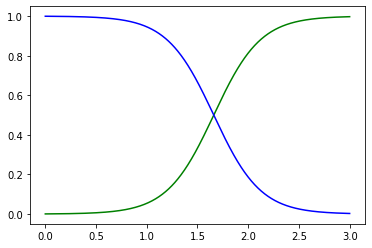

In [34]:
X_new=np.linspace(0,3,1000).reshape(-1,1)
y_proba=log_reg.predict_proba(X_new)
plt.plot(X_new, y_proba[:, 1], 'g-', label='Iris virginica')
plt.plot(X_new, y_proba[:, 0], 'b-', label='Not Iris virginica')

# 양쪽 확률이 50%가 되는 1.6cm 근방에서 결정 경계가 만들어질 것

In [35]:
log_reg.predict([[1.7], [1.5]])

array([1, 0])

- 사이킷런은 로지스틱 회귀를 l2를 기본으로 규제한다.

# 4.6.4 소프트맥스 회귀
- 로지스틱 회귀 모델은 여러 개의 이진 분류기를 훈련시켜 연결하지 않고 직접 다중 클래스를 지원하도록 일반화될 수 있음 = 소프트맥스 회귀, 다항 로지스틱 회귀
- 샘플이 주어지면 소프트맥스 회귀 모델이 각 클래스 k에 대한 점수를 계산하고, 그 점수에 소프트맥스 함수를 적용하여 각 클래스의 확률을 추정
- 각 클래스는 자신만의 파라미터 벡터 theta가 있음: 파라미터 행렬에 행으로 저장
- 샘플에 대해 각 클래스의 점수가 계산되면 소프트맥스 함수를 통과시켜 클래스 k에 속할 확률을 추정
- 이 함수는 각 점수에 지수 함수를 적용한 후 정규화(모든 지수 함수 결과의 합으로 나눔): 로짓 또는 로그-오즈. 
- 추정 확률이 가장 높은 클래스를 선택.


> - 훈련 방법
- 모델이 타깃 클래스에 대해서는 높은 확률을 추정하도록 하는 것이 목표. 
- 크로스 엔트로피 비용 함수를 최소화 -> 타깃 클래스에 대해 낮은 확률을 예측하는 모델을 억제




# 소프트맥스 회귀를 사용해 붓꽃을 세 개 클래스로 분류

In [36]:
X=iris['data'][:, (2,3)] #꽃잎 길이, 꽃잎 너비
y=iris['target']

softmax_reg=LogisticRegression(multi_class='multinomial', solver='lbfgs', C=10)
softmax_reg.fit(X, y)

LogisticRegression(C=10, multi_class='multinomial')

#꽃잎 길이가 5, 너비가 2인 붓꽃 발견 가정: 붓꽃의 품종은?

In [37]:
softmax_reg.predict([[5,2]])

array([2])

In [38]:
softmax_reg.predict_proba([[5,2]])

array([[6.38014896e-07, 5.74929995e-02, 9.42506362e-01]])